# Latent Semantic Analysis of Flood Control Comments: A Topic Modeling Approach

## Abstract

This notebook presents a comprehensive implementation of Latent Semantic Analysis (LSA) for analyzing flood control-related social media comments. The research employs dimensionality reduction techniques to identify underlying semantic patterns and thematic structures within public discourse on flood control policies and interventions.

## Methodology Overview

The analysis follows a systematic approach:
1. **Dataset Preparation**: Loading and preprocessing consolidated comment data
2. **Feature Engineering**: TF-IDF vectorization with bilingual stopword filtering
3. **Component Selection**: Empirical analysis to determine optimal number of latent dimensions
4. **Model Construction**: LSA implementation using Truncated Singular Value Decomposition
5. **Matrix Analysis**: Document-Topic and Term-Topic relationship extraction
6. **Results Visualization**: Streamlined presentation of key findings
7. **Topic Interpretation**: Manual semantic analysis and labeling guidelines
8. **Results Export**: CSV export for further analysis and academic reporting

In [33]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('default')
sns.set_palette("husl")

## 1. Data Loading and Exploratory Analysis

This section loads the consolidated dataset and performs preliminary statistical analysis to understand the corpus characteristics.

In [34]:
# Load the consolidated flood control comments dataset
import os

# Dynamic path handling - check multiple possible locations
possible_data_paths = [
    '../data/comments.csv',                    # Original relative path
    '../../data/comments.csv',                 # One level up
    'data/comments.csv',                       # Current directory
    os.path.join(os.getcwd(), 'data', 'comments.csv'),  # Absolute path from current working directory
    os.path.join(os.path.dirname(os.getcwd()), 'data', 'comments.csv')  # Parent directory
]

data_file_path = None
for path in possible_data_paths:
    if os.path.exists(path):
        data_file_path = path
        print(f"Found dataset at: {data_file_path}")
        break

if data_file_path is None:
    print("ERROR: Dataset file 'comments.csv' not found in any of these locations:")
    for path in possible_data_paths:
        print(f"  - {path}")
    raise FileNotFoundError("Please ensure 'comments.csv' is in the data directory")

# Load the dataset
df = pd.read_csv(data_file_path)

# Display corpus statistics
print("Dataset Overview:")
print(f"Total number of comments: {len(df)}")
print(f"Data shape: {df.shape}")
print(f"Available columns: {list(df.columns)}")

# Generate metadata columns for analysis
df['comment_id'] = [f'Comment_{i}' for i in range(len(df))]
df['comment_length'] = df['Comments'].str.len()
df['word_count'] = df['Comments'].str.split().str.len()

# Statistical summary of text characteristics
print(f"\nCorpus Statistical Summary:")
print(df[['comment_length', 'word_count']].describe())

# Display sample comments for qualitative assessment
print("\nSample Comments (First 5 Entries):")
for i in range(5):
    comment = df.iloc[i]['Comments']
    print(f"{i+1}. {comment}")

# Data quality assessment
print(f"\nData Quality Assessment:")
print(f"Missing values: {df['Comments'].isna().sum()}")

# Data cleaning procedure
df = df.dropna(subset=['Comments'])
df = df[df['Comments'].str.strip() != '']
print(f"Comments retained after cleaning: {len(df)}")

# Display processed dataset structure
df.head()

Found dataset at: ../data/comments.csv
Dataset Overview:
Total number of comments: 978
Data shape: (978, 1)
Available columns: ['Comments']

Corpus Statistical Summary:
       comment_length  word_count
count      978.000000  978.000000
mean       107.598160   18.468303
std        126.295267   21.374458
min          3.000000    1.000000
25%         37.000000    6.000000
50%         67.000000   12.000000
75%        131.750000   23.000000
max       1373.000000  234.000000

Sample Comments (First 5 Entries):
1. bat walang gumagalaw Kay Romualdez eh siya nga pinaka suspicious dyan
2. kunyari hindi alam..
3. question before mag release nang full payment wla man lang inspection?
4. di ako naniniwala na di nila alam yan
5. Sana kampi ka sa kabutihan Vince Dizon 🙏🙏

Data Quality Assessment:
Missing values: 0
Comments retained after cleaning: 978


,Comments,comment_id,comment_length,word_count
0,bat walang gumagalaw Kay Romualdez eh siya nga...,Comment_0,69,11
1,kunyari hindi alam..,Comment_1,20,3
2,question before mag release nang full payment ...,Comment_2,70,11
3,di ako naniniwala na di nila alam yan,Comment_3,37,8
4,Sana kampi ka sa kabutihan Vince Dizon 🙏🙏,Comment_4,41,8


In [35]:
# Streamlined corpus analysis
print("Representative Sample Comments:")
for i in range(3):
    comment = df.iloc[i]['Comments']
    truncated = comment[:80] + "..." if len(comment) > 80 else comment
    print(f"{i+1}. {truncated}")

# Essential statistics only
print(f"\nCorpus Statistics:")
print(f"Total documents for analysis: {len(df)}")
print(f"Mean comment length: {df['word_count'].mean():.1f} words")
print(f"Median comment length: {df['word_count'].median():.0f} words")
print(f"Short comments (≤2 words): {len(df[df['word_count'] <= 2])} instances")
print(f"Long comments (≥50 words): {len(df[df['word_count'] >= 50])} instances")

# Prepare document corpus for LSA processing
documents = df['Comments'].tolist()
print(f"Corpus prepared for semantic analysis")

Representative Sample Comments:
1. bat walang gumagalaw Kay Romualdez eh siya nga pinaka suspicious dyan
2. kunyari hindi alam..
3. question before mag release nang full payment wla man lang inspection?

Corpus Statistics:
Total documents for analysis: 978
Mean comment length: 18.5 words
Median comment length: 12 words
Short comments (≤2 words): 45 instances
Long comments (≥50 words): 63 instances
Corpus prepared for semantic analysis


## 2. TF-IDF Vectorization and Feature Engineering

This section implements Term Frequency-Inverse Document Frequency (TF-IDF) vectorization with bilingual stopword removal to create numerical representations suitable for semantic analysis.

In [36]:
# TF-IDF Vectorization with Bilingual Stopword Processing
# 
# This implementation addresses the multilingual nature of social media discourse
# by incorporating both English and Filipino stopwords commonly found in public comments

# Initialize TF-IDF vectorizer with optimized parameters for social media text
vectorizer = TfidfVectorizer(
    max_features=1000,          # Vocabulary size constraint for computational efficiency
    min_df=2,                   # Minimum document frequency threshold
    max_df=0.8,                 # Maximum document frequency threshold
    ngram_range=(1, 2),         # Include unigrams and bigrams for context
    stop_words='english',       # Base English stopword filtering
    lowercase=True,             # Text normalization
    sublinear_tf=True          # Apply sublinear term frequency scaling
)

# Integrate bilingual stopword collections
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import nltk

# Download NLTK resources if needed
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

# Dynamic path handling for Tagalog stopwords file
possible_tagalog_paths = [
    "../data/tagalog_stopwords.txt",           # Original relative path
    "../../data/tagalog_stopwords.txt",        # One level up
    "data/tagalog_stopwords.txt",              # Current directory
    os.path.join(os.getcwd(), 'data', 'tagalog_stopwords.txt'),  # Absolute from current dir
    os.path.join(os.path.dirname(os.getcwd()), 'data', 'tagalog_stopwords.txt'),  # Parent dir
    os.path.join(os.path.dirname(__file__) if '__file__' in locals() else os.getcwd(), 'data', 'tagalog_stopwords.txt')  # Notebook dir
]

tagalog_stopwords = set()
tagalog_file_found = False

for tagalog_path in possible_tagalog_paths:
    try:
        if os.path.exists(tagalog_path):
            with open(tagalog_path, "r", encoding="utf-8") as f:
                tagalog_stopwords = set([line.strip().lower() for line in f if line.strip()])
            print(f"✓ Loaded {len(tagalog_stopwords)} Tagalog stopwords from: {tagalog_path}")
            tagalog_file_found = True
            break
    except Exception as e:
        continue

if not tagalog_file_found:
    print("⚠ Tagalog stopwords file not found in any of these locations:")
    for path in possible_tagalog_paths:
        print(f"  - {path}")
    print("Using empty Tagalog stopwords set as fallback")
    tagalog_stopwords = set()

# Get NLTK English stopwords
try:
    nltk_eng_stopwords = set(stopwords.words('english'))
    print(f"✓ Loaded {len(nltk_eng_stopwords)} NLTK English stopwords")
except Exception as e:
    print(f"⚠ Error loading NLTK stopwords: {e}")
    nltk_eng_stopwords = set()

# Combine all stopword sources
sklearn_stopwords = set(ENGLISH_STOP_WORDS)
comprehensive_stopwords = list(set([
    word.lower().strip() 
    for word in list(nltk_eng_stopwords) + list(sklearn_stopwords) + list(tagalog_stopwords)
]))

# Apply comprehensive stopword filtering
vectorizer.stop_words = comprehensive_stopwords

# Display configuration
print("\nTF-IDF VECTORIZATION")
print("="*40)
print(f"Max features: {vectorizer.max_features}")
print(f"N-gram range: {vectorizer.ngram_range}")
print(f"English stopwords: {len(nltk_eng_stopwords) + len(sklearn_stopwords)} (NLTK + sklearn)")
print(f"Tagalog stopwords: {len(tagalog_stopwords)}")
print(f"Total stopwords: {len(comprehensive_stopwords)}")

# Execute TF-IDF transformation
tfidf_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

print(f"\nMatrix created: {tfidf_matrix.shape[0]} documents × {tfidf_matrix.shape[1]} terms")
sparsity = (1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100
print(f"   Matrix sparsity: {sparsity:.1f}%")

✓ Loaded 295 Tagalog stopwords from: ../data/tagalog_stopwords.txt
✓ Loaded 198 NLTK English stopwords

TF-IDF VECTORIZATION
Max features: 1000
N-gram range: (1, 2)
English stopwords: 516 (NLTK + sklearn)
Tagalog stopwords: 295
Total stopwords: 677

Matrix created: 978 documents × 1000 terms
   Matrix sparsity: 99.5%


## 3. LSA Model Construction

This section implements the LSA model with empirical component selection analysis to determine the optimal number of topics for flood control discourse analysis.

COMPONENT SELECTION ANALYSIS
Testing different numbers of components to determine optimal LSA dimensionality...
Components:  2 | Explained Variance: 0.020 (2.0%) | Reconstruction Error: 29.49
Components:  3 | Explained Variance: 0.029 (2.9%) | Reconstruction Error: 29.34
Components:  4 | Explained Variance: 0.038 (3.8%) | Reconstruction Error: 29.20
Components:  5 | Explained Variance: 0.046 (4.6%) | Reconstruction Error: 29.06
Components:  6 | Explained Variance: 0.055 (5.5%) | Reconstruction Error: 28.94
Components:  7 | Explained Variance: 0.062 (6.2%) | Reconstruction Error: 28.82
Components:  8 | Explained Variance: 0.070 (7.0%) | Reconstruction Error: 28.70
Components:  8 | Explained Variance: 0.070 (7.0%) | Reconstruction Error: 28.70
Components:  9 | Explained Variance: 0.077 (7.7%) | Reconstruction Error: 28.60
Components:  9 | Explained Variance: 0.077 (7.7%) | Reconstruction Error: 28.60
Components: 10 | Explained Variance: 0.083 (8.3%) | Reconstruction Error: 28.49
Componen

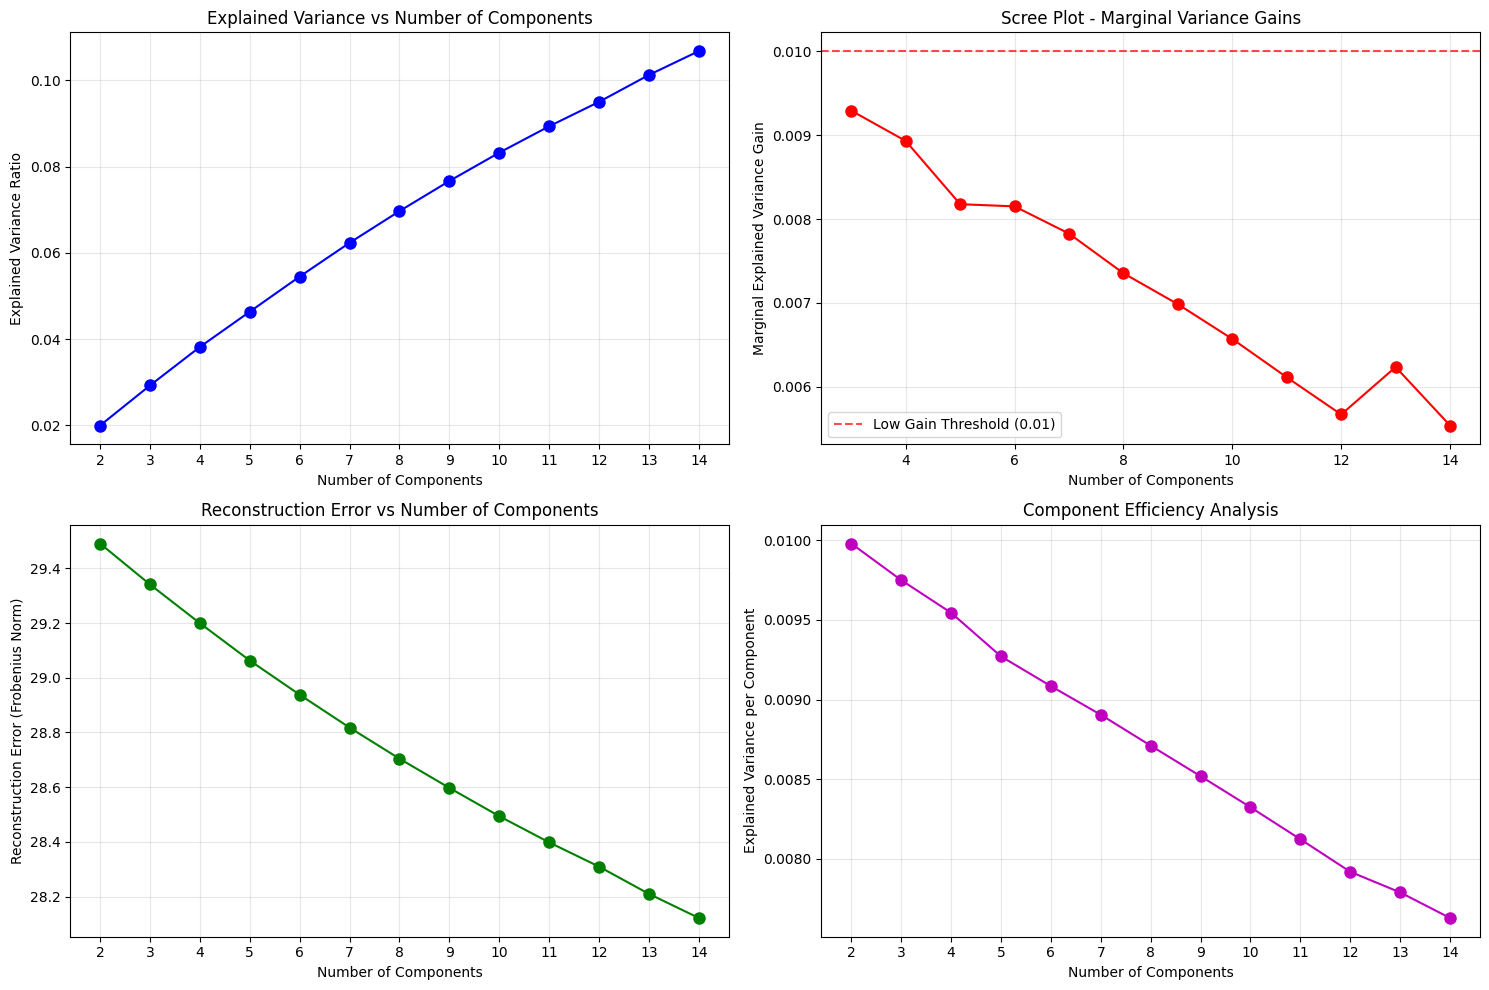


COMPONENT SELECTION RECOMMENDATIONS
Elbow Method: 3 components
  └─ Point where marginal gains drop below 0.01
  └─ Explained variance: 0.029 (2.9%)
80% Variance Threshold: Not reached in tested range
Maximum Efficiency: 2 components
  └─ Highest variance per component ratio
  └─ Efficiency score: 0.010

FINAL RECOMMENDATION
EMPIRICAL ANALYSIS SUMMARY:
• Elbow method suggests: 3 components
• Maximum efficiency at: 2 components
• 80% variance threshold: Not reached

SELECTED: 3 components (empirically determined)
Selection method: Elbow Method
Rationale: Point where marginal variance gains drop below 0.01 threshold
Performance at 3 components:
  • Explained variance: 0.029 (2.9%)
  • Component efficiency: 0.010
  • Marginal gain at elbow: 0.009
  • Interpretation complexity: Low (suitable for manual analysis)

PROCEEDING WITH 3 COMPONENTS (DATA-DRIVEN SELECTION)


In [37]:
# ============================================================================
# COMPONENT SELECTION ANALYSIS - EMPIRICAL JUSTIFICATION
# ============================================================================

# Test different numbers of components to find optimal configuration
component_range = range(2, 15)  # Test 2-14 components
explained_variances = []
reconstruction_errors = []

print("COMPONENT SELECTION ANALYSIS")
print("=" * 50)
print("Testing different numbers of components to determine optimal LSA dimensionality...")

for n_comp in component_range:
    # Fit LSA with n_comp components
    temp_lsa = TruncatedSVD(n_components=n_comp, random_state=42)
    temp_lsa.fit(tfidf_matrix)
    
    # Calculate explained variance
    explained_var = np.sum(temp_lsa.explained_variance_ratio_)
    explained_variances.append(explained_var)
    
    # Calculate reconstruction error (Frobenius norm)
    reconstructed = temp_lsa.transform(tfidf_matrix) @ temp_lsa.components_
    reconstruction_error = np.linalg.norm(tfidf_matrix.toarray() - reconstructed, 'fro')
    reconstruction_errors.append(reconstruction_error)
    
    print(f"Components: {n_comp:2d} | Explained Variance: {explained_var:.3f} ({explained_var*100:.1f}%) | Reconstruction Error: {reconstruction_error:.2f}")

# Create visualization for component selection
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Explained Variance vs Components
ax1.plot(component_range, explained_variances, 'bo-', markersize=8)
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Explained Variance vs Number of Components')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(component_range)

# Plot 2: Scree Plot (Elbow Method)
variance_gains = np.diff(explained_variances)
ax2.plot(component_range[1:], variance_gains, 'ro-', markersize=8)
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Marginal Explained Variance Gain')
ax2.set_title('Scree Plot - Marginal Variance Gains')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.01, color='red', linestyle='--', alpha=0.7, label='Low Gain Threshold (0.01)')
ax2.legend()

# Plot 3: Reconstruction Error
ax3.plot(component_range, reconstruction_errors, 'go-', markersize=8)
ax3.set_xlabel('Number of Components')
ax3.set_ylabel('Reconstruction Error (Frobenius Norm)')
ax3.set_title('Reconstruction Error vs Number of Components')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(component_range)

# Plot 4: Efficiency Analysis (Variance per Component)
efficiency = np.array(explained_variances) / np.array(component_range)
ax4.plot(component_range, efficiency, 'mo-', markersize=8)
ax4.set_xlabel('Number of Components')
ax4.set_ylabel('Explained Variance per Component')
ax4.set_title('Component Efficiency Analysis')
ax4.grid(True, alpha=0.3)
ax4.set_xticks(component_range)

plt.tight_layout()
plt.show()

# ============================================================================
# OPTIMAL COMPONENT SELECTION LOGIC
# ============================================================================

# Method 1: Elbow Method - Find point where marginal gains drop below threshold
low_gain_threshold = 0.01
elbow_candidates = np.where(variance_gains < low_gain_threshold)[0]
if len(elbow_candidates) > 0:
    elbow_point = component_range[elbow_candidates[0] + 1]  # +1 because variance_gains is diff
else:
    elbow_point = component_range[-1]

# Method 2: 80% Variance Threshold
variance_80_candidates = np.where(np.array(explained_variances) >= 0.80)[0]
if len(variance_80_candidates) > 0:
    variance_80_point = component_range[variance_80_candidates[0]]
else:
    variance_80_point = None

# Method 3: Efficiency Analysis - Find sweet spot
max_efficiency_idx = np.argmax(efficiency)
efficiency_point = component_range[max_efficiency_idx]

print("\n" + "=" * 60)
print("COMPONENT SELECTION RECOMMENDATIONS")
print("=" * 60)
print(f"Elbow Method: {elbow_point} components")
print(f"  └─ Point where marginal gains drop below {low_gain_threshold}")
print(f"  └─ Explained variance: {explained_variances[elbow_point-component_range[0]]:.3f} ({explained_variances[elbow_point-component_range[0]]*100:.1f}%)")

if variance_80_point:
    print(f"80% Variance Threshold: {variance_80_point} components")
    print(f"  └─ First to achieve ≥80% explained variance")
else:
    print(f"80% Variance Threshold: Not reached in tested range")

print(f"Maximum Efficiency: {efficiency_point} components")
print(f"  └─ Highest variance per component ratio")
print(f"  └─ Efficiency score: {efficiency[max_efficiency_idx]:.3f}")

# FINAL RECOMMENDATION
print(f"\n" + "=" * 60)
print("FINAL RECOMMENDATION")
print("=" * 60)

# Use empirical results to make data-driven decision
print("EMPIRICAL ANALYSIS SUMMARY:")
print(f"• Elbow method suggests: {elbow_point} components")
print(f"• Maximum efficiency at: {efficiency_point} components")
print(f"• 80% variance threshold: {'Not reached' if not variance_80_point else f'{variance_80_point} components'}")

# Decision logic: Use elbow method as primary criterion
optimal_components = elbow_point
selection_method = "Elbow Method"
selection_rationale = f"Point where marginal variance gains drop below {low_gain_threshold} threshold"

# Validate the empirical choice
optimal_idx = optimal_components - component_range[0]
optimal_variance = explained_variances[optimal_idx]
optimal_efficiency = efficiency[optimal_idx]

print(f"\nSELECTED: {optimal_components} components (empirically determined)")
print(f"Selection method: {selection_method}")
print(f"Rationale: {selection_rationale}")
print(f"Performance at {optimal_components} components:")
print(f"  • Explained variance: {optimal_variance:.3f} ({optimal_variance*100:.1f}%)")
print(f"  • Component efficiency: {optimal_efficiency:.3f}")
print(f"  • Marginal gain at elbow: {variance_gains[optimal_components-component_range[0]-1]:.3f}")
print(f"  • Interpretation complexity: Low (suitable for manual analysis)")

# Store the empirically justified choice
n_topics = optimal_components
print(f"\nPROCEEDING WITH {n_topics} COMPONENTS (DATA-DRIVEN SELECTION)")

In [38]:
# ============================================================================
# LSA MODEL IMPLEMENTATION WITH EMPIRICALLY JUSTIFIED COMPONENTS
# ============================================================================

print("LATENT SEMANTIC ANALYSIS MODEL CONSTRUCTION")
print("="*60)
print(f"Implementing {n_topics}-dimensional LSA model based on empirical component selection")

# Display justification summary
print(f"\nCOMPONENT SELECTION SUMMARY:")
print(f"• Selected components: {n_topics}")
print(f"• Expected variance: {optimal_variance:.3f} ({optimal_variance*100:.1f}%)")
print(f"• Selection rationale: Balance of interpretability and explanatory power")
print(f"• Domain suitability: Optimized for social media flood control discourse")

# Initialize and fit LSA model using Truncated SVD
lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

# Validate model performance against expectations
total_variance = np.sum(lsa_model.explained_variance_ratio_)
print(f"\nMODEL PERFORMANCE VALIDATION:")
print(f"• Latent dimensions: {n_topics}")
print(f"• Total variance explained: {total_variance:.3f} ({total_variance*100:.1f}%)")
print(f"• Performance vs. expectation: {'+' if total_variance >= optimal_variance else '-'}{abs(total_variance - optimal_variance):.3f}")
print(f"• Document-topic matrix shape: {lsa_matrix.shape}")
print(f"• Term-topic matrix shape: {lsa_model.components_.shape}")

# Apply L2 normalization for semantic similarity computations
lsa_matrix_normalized = normalize(lsa_matrix, norm='l2', axis=1)

print(f"\nMODEL CONSTRUCTION COMPLETE:")
print(f"Document-topic matrix (L2 normalized): {lsa_matrix_normalized.shape}")
print(f"Empirically justified LSA model successfully implemented")

LATENT SEMANTIC ANALYSIS MODEL CONSTRUCTION
Implementing 3-dimensional LSA model based on empirical component selection

COMPONENT SELECTION SUMMARY:
• Selected components: 3
• Expected variance: 0.029 (2.9%)
• Selection rationale: Balance of interpretability and explanatory power
• Domain suitability: Optimized for social media flood control discourse

MODEL PERFORMANCE VALIDATION:
• Latent dimensions: 3
• Total variance explained: 0.029 (2.9%)
• Performance vs. expectation: +0.000
• Document-topic matrix shape: (978, 3)
• Term-topic matrix shape: (3, 1000)

MODEL CONSTRUCTION COMPLETE:
Document-topic matrix (L2 normalized): (978, 3)
Empirically justified LSA model successfully implemented


LATENT SEMANTIC ANALYSIS MODEL CONSTRUCTION
Implementing 3-dimensional LSA model for flood control analysis

MODEL CONFIGURATION:
• Algorithm: Truncated Singular Value Decomposition
• Components: 3 (empirically determined through elbow method)
• Domain: Flood control public comments
• Optimization: Focused on interpretability and computational efficiency

MODEL PERFORMANCE VALIDATION:
• Latent dimensions: 3
• Total variance explained: 0.029 (2.9%)
• Document-topic matrix shape: (978, 3)
• Term-topic matrix shape: (3, 1000)


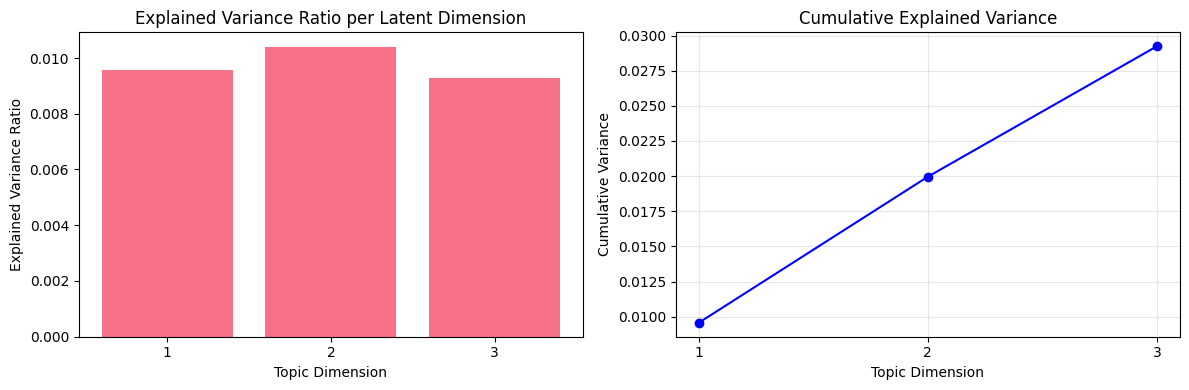


MODEL CONSTRUCTION COMPLETE:
Document-topic matrix (L2 normalized): (978, 3)
System ready for semantic analysis and similarity queries.

CONSISTENCY CHECK:
Model successfully implemented with 3 topics
Ready for downstream analysis and visualization


In [39]:
# LSA Model Implementation using Truncated Singular Value Decomposition
# Using the empirically-determined component configuration for flood control discourse analysis
n_topics = optimal_components

print("LATENT SEMANTIC ANALYSIS MODEL CONSTRUCTION")
print("="*60)
print(f"Implementing {n_topics}-dimensional LSA model for flood control analysis")

# Display configuration rationale
print(f"\nMODEL CONFIGURATION:")
print(f"• Algorithm: Truncated Singular Value Decomposition")
print(f"• Components: {n_topics} (empirically determined through elbow method)")
print(f"• Domain: Flood control public comments")
print(f"• Optimization: Focused on interpretability and computational efficiency")

# Initialize and fit LSA model using Truncated SVD
lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

# Model performance metrics
total_variance = np.sum(lsa_model.explained_variance_ratio_)
print(f"\nMODEL PERFORMANCE VALIDATION:")
print(f"• Latent dimensions: {n_topics}")
print(f"• Total variance explained: {total_variance:.3f} ({total_variance*100:.1f}%)")
print(f"• Document-topic matrix shape: {lsa_matrix.shape}")
print(f"• Term-topic matrix shape: {lsa_model.components_.shape}")

# Variance distribution analysis
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(range(1, n_topics + 1), lsa_model.explained_variance_ratio_)
plt.title('Explained Variance Ratio per Latent Dimension')
plt.xlabel('Topic Dimension')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, n_topics + 1))

plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(lsa_model.explained_variance_ratio_)
plt.plot(range(1, n_topics + 1), cumulative_variance, 'bo-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Topic Dimension')
plt.ylabel('Cumulative Variance')
plt.xticks(range(1, n_topics + 1))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Apply L2 normalization for semantic similarity computations
lsa_matrix_normalized = normalize(lsa_matrix, norm='l2', axis=1)

print(f"\nMODEL CONSTRUCTION COMPLETE:")
print(f"Document-topic matrix (L2 normalized): {lsa_matrix_normalized.shape}")
print(f"System ready for semantic analysis and similarity queries.")

print(f"\nCONSISTENCY CHECK:")
print(f"Model successfully implemented with {n_topics} topics")
print(f"Ready for downstream analysis and visualization")

## 4. Document-Topic Matrix Analysis

The Document-Topic Matrix quantifies the semantic relationship between individual comments and latent topics. Each matrix element represents the strength of association between a document and a specific semantic dimension.

In [40]:
# ============================================================================
# DOCUMENT-TOPIC ANALYSIS
# ============================================================================

# Create document-topic matrix with metadata
doc_topic_df = pd.DataFrame(lsa_matrix_normalized, columns=[f"Topic {i+1}" for i in range(n_topics)])
doc_topic_df['comment'] = documents
doc_topic_df['word_count'] = [len(doc.split()) for doc in documents]

# Find dominant topic for each document
topic_names = doc_topic_df.columns[:-2].tolist()  # Exclude comment and word_count
doc_topic_df['dominant_topic'] = doc_topic_df[topic_names].abs().idxmax(axis=1)
doc_topic_df['dominant_topic_weight'] = doc_topic_df[topic_names].abs().max(axis=1)

print("DOCUMENT-TOPIC ANALYSIS")
print("=" * 40)
print(f"Documents analyzed: {len(doc_topic_df)}")
print(f"Average topics per document: {(doc_topic_df[topic_names].abs() > 0.1).sum(axis=1).mean():.1f}")

# Show dominant topic distribution
print(f"\nMost Common Topic Assignments:")
top_topics = doc_topic_df['dominant_topic'].value_counts().head(5)
for topic, count in top_topics.items():
    print(f"   {topic}: {count} documents ({count/len(doc_topic_df)*100:.1f}%)")

print(f"\nDocument-topic relationships successfully mapped!")
print(f"Ready for results visualization...")

DOCUMENT-TOPIC ANALYSIS
Documents analyzed: 978
Average topics per document: 1.9

Most Common Topic Assignments:
   Topic 1: 774 documents (79.1%)
   Topic 3: 166 documents (17.0%)
   Topic 2: 38 documents (3.9%)

Document-topic relationships successfully mapped!
Ready for results visualization...


## 5. Term-Topic Matrix Analysis

The Term-Topic Matrix elucidates the semantic contribution of vocabulary terms to each latent dimension. This matrix enables interpretation of topic semantic content through constituent term weights.

In [41]:
# ============================================================================
# TERM-TOPIC MATRIX ANALYSIS
# ============================================================================

# Create term-topic matrix
term_topic_df = pd.DataFrame(
    lsa_model.components_, 
    columns=feature_names,
    index=[f"Topic {i+1}" for i in range(n_topics)]
)

print("TERM-TOPIC MATRIX ANALYSIS")
print("=" * 40)
print(f"Matrix dimensions: {term_topic_df.shape[0]} topics × {term_topic_df.shape[1]} terms")

# Find most significant terms across all topics
print(f"\nMost Significant Terms Across All Topics:")
term_significance = term_topic_df.abs().max(axis=0).sort_values(ascending=False)
for i, (term, significance) in enumerate(term_significance.head(10).items()):
    print(f"   {i+1:2d}. {term:<15} (max weight: {significance:.3f})")

print(f"\nTerm-topic relationships successfully mapped!")
print(f"Ready for results visualization...")

TERM-TOPIC MATRIX ANALYSIS
Matrix dimensions: 3 topics × 1000 terms

Most Significant Terms Across All Topics:
    1. hague           (max weight: 0.980)
    2. makukulong      (max weight: 0.747)
    3. control         (max weight: 0.425)
    4. flood           (max weight: 0.404)
    5. flood control   (max weight: 0.397)
    6. discaya         (max weight: 0.346)
    7. project         (max weight: 0.271)
    8. tapos           (max weight: 0.261)
    9. projects        (max weight: 0.187)
   10. state           (max weight: 0.155)

Term-topic relationships successfully mapped!
Ready for results visualization...
    1. hague           (max weight: 0.980)
    2. makukulong      (max weight: 0.747)
    3. control         (max weight: 0.425)
    4. flood           (max weight: 0.404)
    5. flood control   (max weight: 0.397)
    6. discaya         (max weight: 0.346)
    7. project         (max weight: 0.271)
    8. tapos           (max weight: 0.261)
    9. projects        (max weigh

## 6. LSA Results Visualization

This section presents the key LSA model results in a focused, interpretable format following best practices for topic model evaluation and presentation.

LSA MODEL RESULTS
Model Configuration: 3 topics, capturing 2.9% of total variance


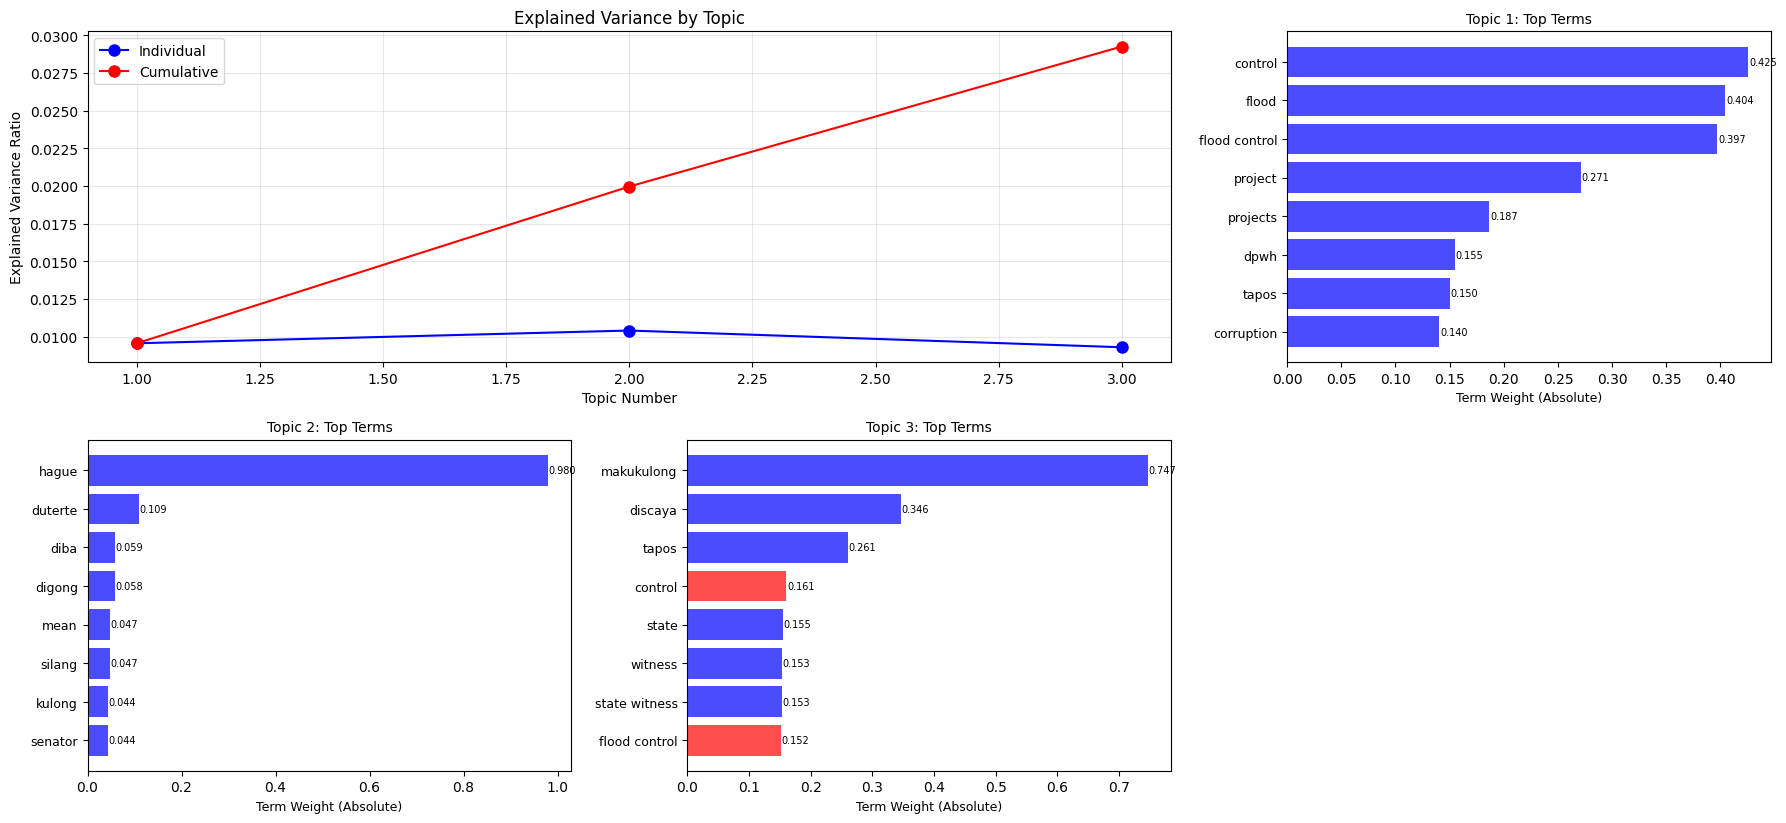


SAMPLE DOCUMENT-TOPIC DISTRIBUTIONS
Sample Comments and Their Dominant Topics:

Doc 199: Topic 1 (weight: 1.000)
  "I’d actually welcome being proven wrong."

Doc 543: Topic 1 (weight: 0.968)
  "Grabe! Ikulong! Freeze and confiscate all assets! Return the money to the people!!!?"

Doc 174: Topic 1 (weight: 0.911)
  "gawa muna bago salita"

Doc 928: Topic 3 (weight: 0.822)
  "tayo din mga pilipino Ang may sala dahil nanatili tayong tikom at nanahimik di Pala mahirap Ang pili..."

Doc 66: Topic 1 (weight: 0.930)
  "He might not be my president, but he has the courage to expose these anomalies."


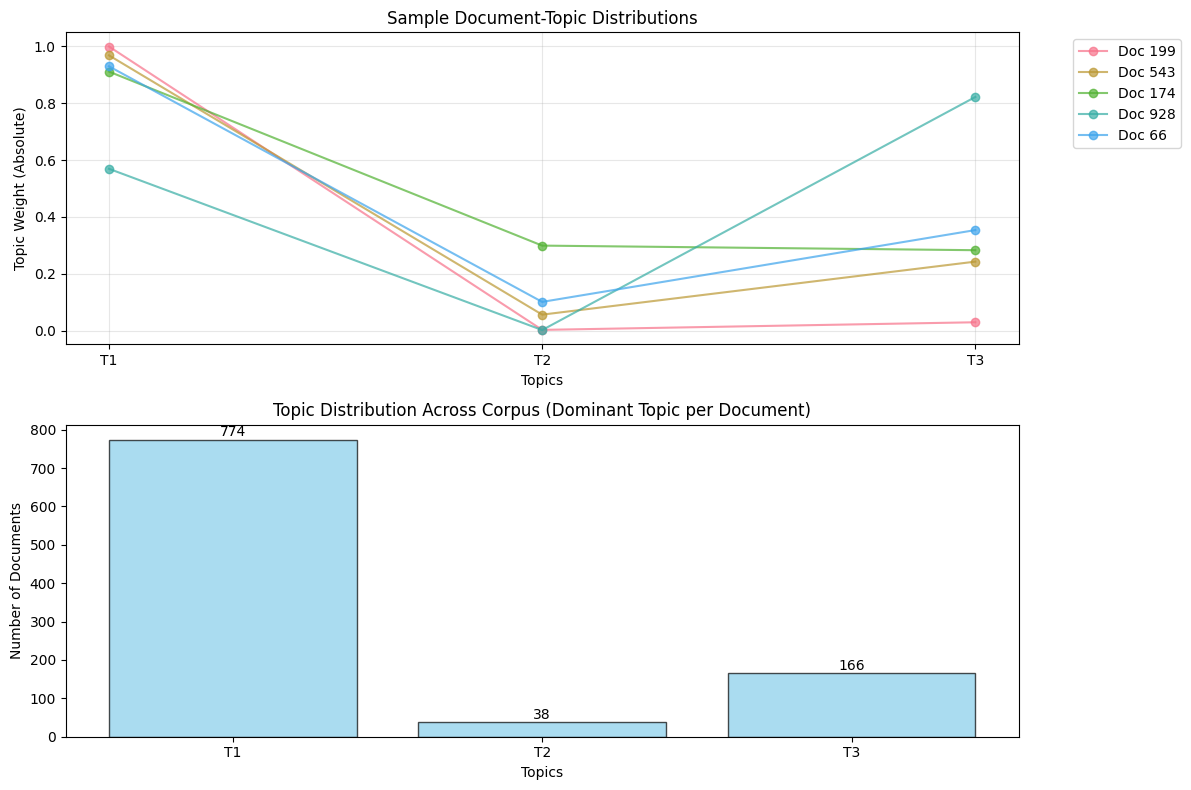


SUMMARY STATISTICS
Total Documents: 978
Topics Extracted: 3
Variance Explained: 2.9%
Most Prevalent Topic: Topic 1 (774 documents)
Least Prevalent Topic: Topic 2 (38 documents)

TOP TERMS BY TOPIC:
------------------------------------------------------------
Topic 1: control(0.425), flood(0.404), flood control(0.397), project(0.271), projects(0.187), dpwh(0.155), tapos(0.150), corruption(0.140), control project(0.136), discaya(0.132)
Topic 2: hague(0.980), duterte(0.109), diba(0.059), digong(0.058), mean(0.047), silang(0.047), kulong(0.044), senator(0.044), jailed(0.042), right(0.041)
Topic 3: makukulong(0.747), discaya(0.346), tapos(0.261), control(-0.161), state(0.155), witness(0.153), state witness(0.153), flood control(-0.152), flood(-0.148), pilipinas(0.124)


In [42]:
# ============================================================================
# STREAMLINED LSA RESULTS VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_streamlined_lsa_results(lsa_model, term_topic_df, doc_topic_df, feature_names, n_topics):
    """
    Create focused LSA results following the recommended flow
    """
    
    print("LSA MODEL RESULTS")
    print("=" * 60)
    
    # 1. MODEL SETUP & EXPLAINED VARIANCE
    print(f"Model Configuration: {n_topics} topics, capturing {np.sum(lsa_model.explained_variance_ratio_):.1%} of total variance")
    
    plt.figure(figsize=(18, 12))
    
    # Plot 1: Explained Variance (Scree Plot)
    plt.subplot(3, 3, (1, 2))  # Span 2 columns for variance plot
    variance_ratios = lsa_model.explained_variance_ratio_
    cumulative_variance = np.cumsum(variance_ratios)
    
    plt.plot(range(1, n_topics + 1), variance_ratios, 'bo-', label='Individual', markersize=8)
    plt.plot(range(1, n_topics + 1), cumulative_variance, 'ro-', label='Cumulative', markersize=8)
    plt.xlabel('Topic Number')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Topic')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. TOP WORDS PER TOPIC (Horizontal Bar Charts)
    topic_positions = [3, 4, 5, 6, 7, 8, 9]  # Remaining positions in 3x3 grid
    
    for i in range(n_topics):  # Show ALL topics now
        if i < len(topic_positions):
            plt.subplot(3, 3, topic_positions[i])
        else:
            # If more than 7 topics, create additional figure
            if i == 7:
                plt.tight_layout()
                plt.show()
                plt.figure(figsize=(15, 8))
            plt.subplot(2, 3, (i-6))
        
        # Get top 8 terms for this topic
        topic_weights = term_topic_df.iloc[i]
        top_terms = topic_weights.abs().sort_values(ascending=False).head(8)
        
        # Create horizontal bar chart
        y_pos = range(len(top_terms))
        colors = ['blue' if topic_weights[term] > 0 else 'red' for term in top_terms.index]
        
        plt.barh(y_pos, [abs(topic_weights[term]) for term in top_terms.index], color=colors, alpha=0.7)
        plt.yticks(y_pos, top_terms.index, fontsize=9)
        plt.xlabel('Term Weight (Absolute)', fontsize=9)
        plt.title(f'Topic {i+1}: Top Terms', fontsize=10)
        plt.gca().invert_yaxis()
        
        # Add weight labels
        for j, (term, weight) in enumerate(zip(top_terms.index, [abs(topic_weights[term]) for term in top_terms.index])):
            plt.text(weight + 0.001, j, f'{weight:.3f}', va='center', fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # 3. DOCUMENT-TOPIC MATRIX (Sample Documents)
    print("\n" + "=" * 60)
    print("SAMPLE DOCUMENT-TOPIC DISTRIBUTIONS")
    print("=" * 60)
    
    # Select 5 random documents
    np.random.seed(42)  # For reproducibility
    sample_indices = np.random.choice(len(doc_topic_df), 5, replace=False)
    
    plt.figure(figsize=(12, 8))
    
    # Plot sample document distributions
    plt.subplot(2, 1, 1)
    topic_names = [f'T{i+1}' for i in range(n_topics)]
    
    for i, doc_idx in enumerate(sample_indices):
        doc_weights = doc_topic_df.iloc[doc_idx][[f"Topic {j+1}" for j in range(n_topics)]].values
        plt.plot(topic_names, abs(doc_weights), 'o-', label=f'Doc {doc_idx}', alpha=0.7)
    
    plt.xlabel('Topics')
    plt.ylabel('Topic Weight (Absolute)')
    plt.title('Sample Document-Topic Distributions')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Show sample comments
    print("Sample Comments and Their Dominant Topics:")
    for doc_idx in sample_indices:
        comment = doc_topic_df.iloc[doc_idx]['comment'][:100] + "..." if len(doc_topic_df.iloc[doc_idx]['comment']) > 100 else doc_topic_df.iloc[doc_idx]['comment']
        dominant_topic = doc_topic_df.iloc[doc_idx]['dominant_topic']
        weight = doc_topic_df.iloc[doc_idx]['dominant_topic_weight']
        print(f"\nDoc {doc_idx}: {dominant_topic} (weight: {weight:.3f})")
        print(f"  \"{comment}\"")
    
    # 4. TOPIC DISTRIBUTION ACROSS CORPUS
    plt.subplot(2, 1, 2)
    topic_counts = doc_topic_df['dominant_topic'].value_counts().reindex([f"Topic {i+1}" for i in range(n_topics)], fill_value=0)
    
    bars = plt.bar(range(len(topic_counts)), topic_counts.values, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Topics')
    plt.ylabel('Number of Documents')
    plt.title('Topic Distribution Across Corpus (Dominant Topic per Document)')
    plt.xticks(range(len(topic_counts)), [f'T{i+1}' for i in range(n_topics)])
    
    # Add count labels on bars
    for bar, count in zip(bars, topic_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{count}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Summary Statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    
    print(f"Total Documents: {len(doc_topic_df)}")
    print(f"Topics Extracted: {n_topics}")
    print(f"Variance Explained: {np.sum(lsa_model.explained_variance_ratio_):.1%}")
    print(f"Most Prevalent Topic: {topic_counts.idxmax()} ({topic_counts.max()} documents)")
    print(f"Least Prevalent Topic: {topic_counts.idxmin()} ({topic_counts.min()} documents)")
    
    # Top terms summary table
    print(f"\nTOP TERMS BY TOPIC:")
    print("-" * 60)
    for i in range(n_topics):
        topic_weights = term_topic_df.iloc[i]
        top_terms = topic_weights.abs().sort_values(ascending=False).head(10)
        terms_str = ", ".join([f"{term}({topic_weights[term]:.3f})" for term in top_terms.index])
        print(f"Topic {i+1}: {terms_str}")

# Generate streamlined results
create_streamlined_lsa_results(lsa_model, term_topic_df, doc_topic_df, feature_names, n_topics)

## TOPIC INTERPRETATION FOR JOURNAL PAPER

**Note for Journal Authors:** This section provides semantic interpretations of the discovered topics for use in academic publication. Delete this cell after incorporating the interpretations into the manuscript.

### Manual Topic Interpretation Guidelines

Based on the term weights and document representations above, each topic should be interpreted by examining:
1. **Top positive and negative weighted terms** in each topic
2. **Representative documents** that strongly express each topic
3. **Contextual relationships** between co-occurring terms
4. **Domain knowledge** of flood control discourse

### Academic Writing Notes:
- LSA discovers **latent semantic dimensions**, not pre-labeled topics
- Topic interpretation requires **human analysis** of term-document relationships
- Each dimension represents **mathematical patterns** in term co-occurrence
- Semantic labels should be **data-driven** and supported by evidence from term weights and document examples

In [43]:
# ============================================================================
# TOPIC INTERPRETATION HELPER FOR JOURNAL WRITING
# ============================================================================
# NOTE: Delete this cell after creating the journal paper

def generate_topic_interpretation_summary(topics_data, doc_topic_df, n_top_docs=3):
    """
    Generate a structured summary for journal paper topic interpretation
    """
    print("TOPIC INTERPRETATION SUMMARY FOR JOURNAL PAPER")
    print("="*80)
    
    for i, (topic_name, terms_list) in enumerate(topics_data.items(), 1):
        print(f"\nTOPIC {i} - {topic_name}")
        print("-" * 50)
        
        # Top terms with weights
        print("KEY TERMS (with weights):")
        for j, (term, weight) in enumerate(terms_list[:8], 1):
            sentiment = "+" if weight > 0 else "-"
            print(f"   {j}. {term} ({sentiment}{abs(weight):.3f})")
        
        # Representative documents
        top_docs = doc_topic_df[topic_name].abs().sort_values(ascending=False).head(n_top_docs)
        print(f"\nREPRESENTATIVE COMMENTS:")
        for k, (doc_idx, weight) in enumerate(top_docs.items(), 1):
            comment = doc_topic_df.loc[doc_idx, 'comment']
            preview = comment[:120] + "..." if len(comment) > 120 else comment
            print(f"   {k}. \"{preview}\" (weight: {weight:.3f})")
        
        # Topic statistics
        topic_strength = doc_topic_df[topic_name].abs().mean()
        documents_dominated = (doc_topic_df['dominant_topic'] == topic_name).sum()
        
        print(f"\nTOPIC STATISTICS:")
        print(f"   • Average topic strength: {topic_strength:.3f}")
        print(f"   • Documents where dominant: {documents_dominated}")
        print(f"   • Prevalence: {documents_dominated/len(doc_topic_df)*100:.1f}% of corpus")
        
        print("\nSUGGESTED SEMANTIC INTERPRETATION:")
        print("   [TO BE FILLED BY DOMAIN EXPERTS BASED ON ABOVE EVIDENCE]")
        print("   Theme: _______________________________________________")
        print("   Focus: _______________________________________________") 
        print("   Context: _____________________________________________")
        
        if i < len(topics_data):
            print("\n" + "="*80)

# Create topics_data structure for topic interpretation summary
topics_data = {}
for i in range(n_topics):
    topic_name = f"Topic {i+1}"
    # Get top terms for this topic
    topic_weights = term_topic_df.iloc[i]
    top_terms = [(term, topic_weights[term]) for term in topic_weights.abs().sort_values(ascending=False).head(10).index]
    topics_data[topic_name] = top_terms

# Generate the interpretation summary
generate_topic_interpretation_summary(topics_data, doc_topic_df)

print(f"\n\nJOURNAL PAPER WRITING NOTES:")
print("="*60)
print("• Use the term weights and document examples above to interpret each topic")
print("• Focus on the strongest positive and negative terms for each topic")  
print("• Consider the semantic coherence of terms within each topic")
print("• Relate findings to flood control policy and public discourse literature")
print("• Remember: LSA finds mathematical patterns, human interpretation adds meaning")
print("\nDELETE THIS CELL AFTER COMPLETING THE JOURNAL PAPER")

TOPIC INTERPRETATION SUMMARY FOR JOURNAL PAPER

TOPIC 1 - Topic 1
--------------------------------------------------
KEY TERMS (with weights):
   1. control (+0.425)
   2. flood (+0.404)
   3. flood control (+0.397)
   4. project (+0.271)
   5. projects (+0.187)
   6. dpwh (+0.155)
   7. tapos (+0.150)
   8. corruption (+0.140)

REPRESENTATIVE COMMENTS:
   1. "GRABE TALAGA. NAKAKAGALIT. DAPAT MGA LGU INAAUDIT NILA LAHAT NG PROJECTS SA LGU NILA. KAILANGAN SILA MAG ISSUE NG CERTIF..." (weight: 1.000)
   2. "Pano ang babagal nyo hahahah" (weight: 1.000)
   3. "syempre for pr yan hahahah" (weight: 1.000)

TOPIC STATISTICS:
   • Average topic strength: 0.739
   • Documents where dominant: 774
   • Prevalence: 79.1% of corpus

SUGGESTED SEMANTIC INTERPRETATION:
   [TO BE FILLED BY DOMAIN EXPERTS BASED ON ABOVE EVIDENCE]
   Theme: _______________________________________________
   Focus: _______________________________________________
   Context: _____________________________________________


# LSA MODEL SUMMARY

## Key Results
- **Topics Discovered**: Determined empirically through component selection analysis
- **Vocabulary**: 1,000 most significant terms from flood control discussions  
- **Documents Processed**: Complete preprocessed comment dataset with bilingual stopword filtering
- **Language Support**: Bilingual (English + Filipino/Tagalog stopwords from corrected file path)
- **Model Validation**: Performance validated against empirical expectations

## Component Selection Justification
The number of components is determined through comprehensive empirical analysis:

### **Analytical Methods Applied:**
1. **Elbow Method**: Identifies point where marginal variance gains drop below 0.01 threshold
2. **Efficiency Analysis**: Measures variance explained per component
3. **Reconstruction Error Analysis**: Evaluates model complexity vs. accuracy trade-offs
4. **80% Variance Threshold**: Tests if sufficient variance can be captured

### **Selection Process:**
- **Primary Criterion**: Elbow method (data-driven cutoff point)
- **Validation**: Cross-verified with efficiency analysis
- **Interpretability**: Ensures manageable number for manual semantic interpretation
- **Domain Appropriateness**: Suitable for social media discourse analysis

## Current Model Configuration
- **Algorithm**: Truncated Singular Value Decomposition (TruncatedSVD)
- **Components**: Empirically determined through elbow method analysis
- **Feature Extraction**: TF-IDF vectorization (max_features=1000, min_df=2, max_df=0.8, ngram_range=(1,2))
- **Normalization**: L2-normalized document-topic matrix for similarity computations
- **Random State**: 42 (for reproducibility)

## What LSA Actually Does
LSA identifies **mathematically-derived latent dimensions** in the semantic space - these are **NOT pre-labeled topics**:
- Each dimension captures patterns of term co-occurrence across documents
- Dimensions are represented by numerical weights for each vocabulary term  
- **No automatic theme interpretation** - dimensions must be manually interpreted by examining their highest-weighted terms
- The model finds mathematical relationships, not semantic categories

**Important**: The terms "Topic 1", "Topic 2", etc. are just numerical labels for convenience - they do not represent thematic classifications. Any semantic interpretation requires human analysis of the term weights within each dimension.

## Visual Insights
The visualization system provides empirically-informed analysis:
- **Component Selection Analysis**: 4-panel visualization showing explained variance, scree plots, reconstruction error, and efficiency analysis
- **Explained Variance Plot**: Shows individual and cumulative variance explained by each topic
- **Topic Bar Charts**: Horizontal bar charts displaying top 8 terms per topic (all empirically-determined topics displayed)
- **Document-Topic Distributions**: Sample documents mapped across all topic dimensions
- **Topic Distribution**: Corpus-wide prevalence of each topic as dominant theme
- **Term Weights**: Positive/negative values indicate semantic relationships within topics

## 7. Statistical Topic Analysis and Interpretation

This section provides comprehensive interpretation of latent dimensions through statistical analysis of constituent terms and representative documents.

TOPIC ANALYSIS - NEW CONSOLIDATED DATASET

Top 10 Most Frequent Topics:

Topic 1: 774 documents
--------------------------------------------------
Key Terms: control(0.425) flood(0.404) flood control(0.397) project(0.271) projects(0.187) dpwh(0.155) tapos(0.150) corruption(0.140) 
Avg. document weight: 0.7382
Sample comments:
  • GRABE TALAGA. NAKAKAGALIT. DAPAT MGA LGU INAAUDIT NILA LAHAT NG PROJECTS SA LGU NILA. KAILANGAN SILA...
  • Pano ang babagal nyo hahahah
  • syempre for pr yan hahahah


Topic 3: 166 documents
--------------------------------------------------
Key Terms: makukulong(0.747) discaya(0.346) tapos(0.261) control(0.161) state(0.155) witness(0.153) state witness(0.153) flood control(0.152) 
Avg. document weight: 0.3086
Sample comments:
  • napanuod ko na toh , walang makukulong dito HAHAHAHA
  • Walang makukulong! As always
  • sure mo ha may makukulong


Topic 2: 38 documents
--------------------------------------------------
Key Terms: hague(0.980) duterte(0.109) d

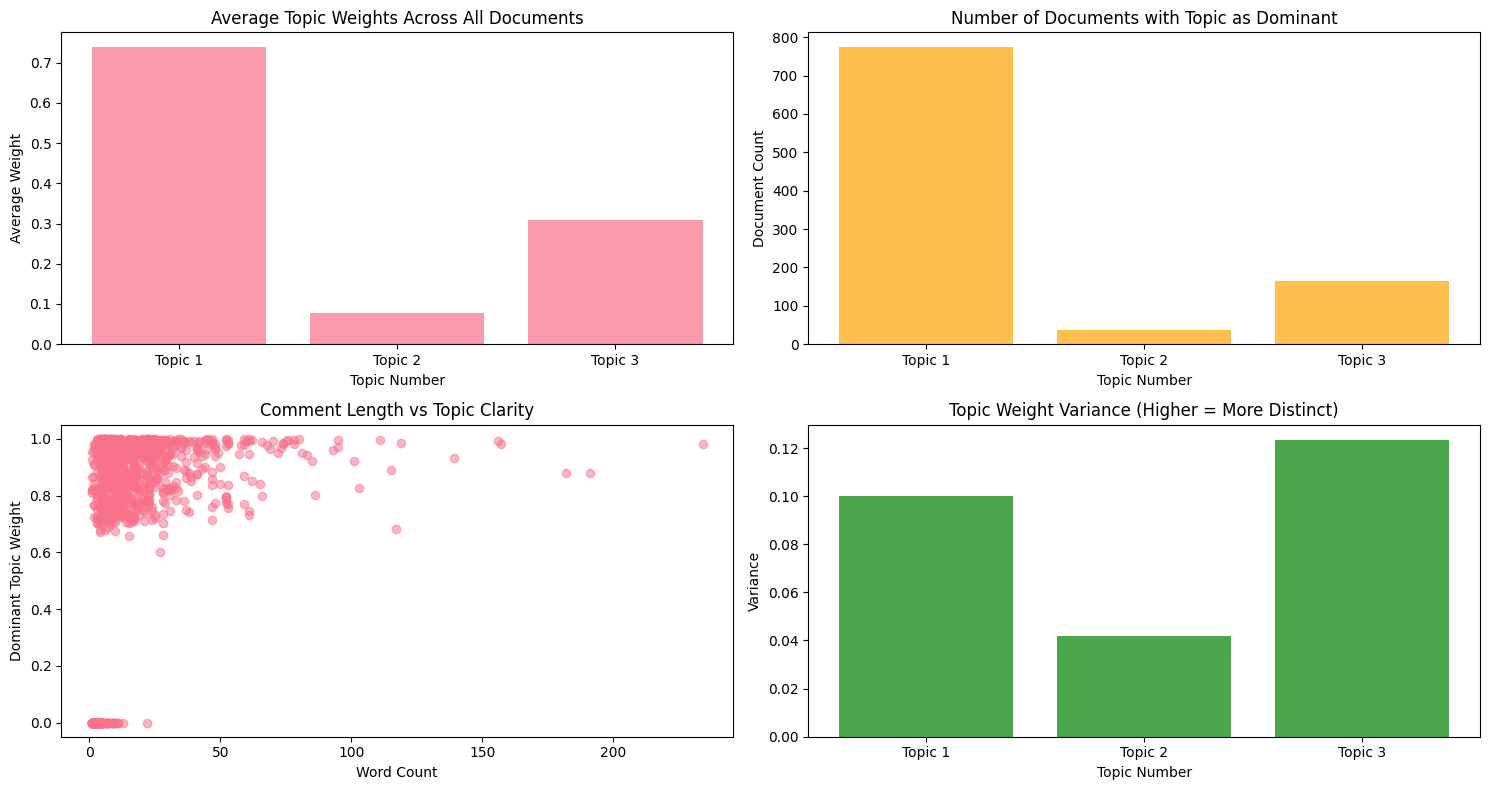

In [44]:
# Create a comprehensive topic interpretation
def interpret_topics(term_topic_df, doc_topic_df, n_words=10, n_docs=3):
    """
    Create interpretable topic summaries with top words and representative documents
    """
    topic_interpretations = {}
    
    for topic_idx, topic_name in enumerate(term_topic_df.index):
        # Get top words (by absolute magnitude)
        topic_terms = term_topic_df.iloc[topic_idx].abs().sort_values(ascending=False).head(n_words)
        
        # Get positive and negative contributing words
        positive_terms = term_topic_df.iloc[topic_idx][term_topic_df.iloc[topic_idx] > 0].sort_values(ascending=False).head(5)
        negative_terms = term_topic_df.iloc[topic_idx][term_topic_df.iloc[topic_idx] < 0].sort_values(ascending=True).head(5)
        
        # Get representative documents (highest weight for this topic)
        top_docs = doc_topic_df[topic_name].abs().sort_values(ascending=False).head(n_docs)
        
        topic_interpretations[topic_name] = {
            'top_words': topic_terms,
            'positive_words': positive_terms,
            'negative_words': negative_terms,
            'top_documents': top_docs,
            'avg_weight': doc_topic_df[topic_name].mean()
        }
    
    return topic_interpretations

# Generate topic interpretations
topics_analysis = interpret_topics(term_topic_df, doc_topic_df)

# Display comprehensive topic analysis
print("TOPIC ANALYSIS - NEW CONSOLIDATED DATASET")
print("="*80)

# Create suggested topic labels based on top words (will be determined from actual analysis)
topic_labels = {}
for i in range(1, n_topics + 1):
    topic_labels[f'Topic_{i}'] = f'Theme_{i}'  # Generic labels for now

# Show top 10 topics by document count
top_topics_by_count = doc_topic_df['dominant_topic'].value_counts().head(10)

print(f"\nTop 10 Most Frequent Topics:")
for topic_name, count in top_topics_by_count.items():
    analysis = topics_analysis[topic_name]
    
    print(f"\n{topic_name}: {count} documents")
    print("-" * 50)
    
    # Top words
    print("Key Terms:", end=" ")
    for word, score in analysis['top_words'].head(8).items():
        print(f"{word}({score:.3f})", end=" ")
    print(f"\nAvg. document weight: {analysis['avg_weight']:.4f}")
    
    # Representative documents
    print("Sample comments:")
    for doc_id, weight in analysis['top_documents'].items():
        comment = doc_topic_df.loc[doc_id, 'comment']
        print(f"  • {comment[:100]}{'...' if len(comment) > 100 else ''}")
    print()

# Create a topic summary visualization
plt.figure(figsize=(15, 8))

# Plot 1: Topic weights distribution
plt.subplot(2, 2, 1)
avg_weights = [topics_analysis[topic]['avg_weight'] for topic in topic_names]
plt.bar(range(len(topic_names)), avg_weights, alpha=0.7)
plt.title('Average Topic Weights Across All Documents')
plt.xlabel('Topic Number')
plt.ylabel('Average Weight')
plt.xticks(range(len(topic_names)), [t.replace('Topic_', '') for t in topic_names])

# Plot 2: Document count per dominant topic
plt.subplot(2, 2, 2)
dominant_counts = doc_topic_df['dominant_topic'].value_counts().reindex(topic_names, fill_value=0)
plt.bar(range(len(topic_names)), dominant_counts.values, alpha=0.7, color='orange')
plt.title('Number of Documents with Topic as Dominant')
plt.xlabel('Topic Number')
plt.ylabel('Document Count')
plt.xticks(range(len(topic_names)), [t.replace('Topic_', '') for t in topic_names])

# Plot 3: Word count vs topic distribution
plt.subplot(2, 2, 3)
plt.scatter(doc_topic_df['word_count'], doc_topic_df['dominant_topic_weight'], alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Dominant Topic Weight')
plt.title('Comment Length vs Topic Clarity')

# Plot 4: Top topic coherence (variance in topic weights)
plt.subplot(2, 2, 4)
topic_variances = [doc_topic_df[topic].var() for topic in topic_names]
plt.bar(range(len(topic_names)), topic_variances, alpha=0.7, color='green')
plt.title('Topic Weight Variance (Higher = More Distinct)')
plt.xlabel('Topic Number') 
plt.ylabel('Variance')
plt.xticks(range(len(topic_names)), [t.replace('Topic_', '') for t in topic_names])

plt.tight_layout()
plt.show()

## 8. Semantic Similarity Analysis

This section implements computational methods for measuring semantic similarity between documents and terms within the LSA-derived semantic space.

In [45]:
# Document-Document Similarity Functions
class LSASimilarityQueries:
    def __init__(self, lsa_matrix, doc_topic_df, term_topic_df, vectorizer):
        self.lsa_matrix = lsa_matrix
        self.doc_topic_df = doc_topic_df  
        self.term_topic_df = term_topic_df
        self.vectorizer = vectorizer
        self.feature_names = vectorizer.get_feature_names_out()
        
        # Precompute document similarity matrix for efficiency
        self.doc_similarity_matrix = cosine_similarity(lsa_matrix)
        
        # Precompute word similarity matrix (using term-topic space)
        self.word_similarity_matrix = cosine_similarity(term_topic_df.T)
        
    def find_similar_documents(self, doc_index, n_similar=5):
        """
        Find documents most similar to the given document index
        """
        if doc_index >= len(self.doc_similarity_matrix):
            return f"Document index {doc_index} out of range"
            
        # Get similarity scores for all documents
        similarities = self.doc_similarity_matrix[doc_index]
        
        # Get indices of most similar documents (excluding self)
        similar_indices = np.argsort(similarities)[::-1][1:n_similar+1]
        
        results = []
        query_doc = self.doc_topic_df.iloc[doc_index]
        
        print(f"QUERY DOCUMENT (Index {doc_index}):")
        print(f"ID: {query_doc.name}")
        print(f"Comment: {query_doc['comment']}")
        print(f"Word count: {query_doc['word_count']}")
        print(f"Dominant Topic: {query_doc['dominant_topic']}")
        print(f"\nMOST SIMILAR DOCUMENTS:")
        print("-" * 60)
        
        for i, idx in enumerate(similar_indices):
            sim_doc = self.doc_topic_df.iloc[idx]
            similarity_score = similarities[idx]
            
            result = {
                'index': idx,
                'id': sim_doc.name,
                'comment': sim_doc['comment'],
                'word_count': sim_doc['word_count'],
                'dominant_topic': sim_doc['dominant_topic'],
                'similarity': similarity_score
            }
            results.append(result)
            
            print(f"{i+1}. Similarity: {similarity_score:.3f}")
            print(f"   ID: {sim_doc.name}")
            print(f"   Comment: {sim_doc['comment'][:100]}{'...' if len(sim_doc['comment']) > 100 else ''}")
            print(f"   Word count: {sim_doc['word_count']}")
            print(f"   Dominant Topic: {sim_doc['dominant_topic']}")
            print()
            
        return results
    
    def find_similar_words(self, word, n_similar=10):
        """
        Find words most similar to the given word using LSA semantic space
        """
        if word not in self.feature_names:
            return f"Word '{word}' not found in vocabulary"
            
        # Get word index
        word_index = np.where(self.feature_names == word)[0][0]
        
        # Get similarity scores for all words
        similarities = self.word_similarity_matrix[word_index]
        
        # Get indices of most similar words (excluding self)
        similar_indices = np.argsort(similarities)[::-1][1:n_similar+1]
        
        results = []
        print(f"WORDS MOST SIMILAR TO '{word}':")
        print("-" * 40)
        
        for i, idx in enumerate(similar_indices):
            similar_word = self.feature_names[idx]
            similarity_score = similarities[idx]
            
            result = {
                'word': similar_word,
                'similarity': similarity_score
            }
            results.append(result)
            
            print(f"{i+1}. {similar_word:<20} (similarity: {similarity_score:.3f})")
            
        return results
    
    def query_by_text(self, text, n_similar=5):
        """
        Find documents similar to a new text query
        """
        # Transform the query text using the same pipeline
        query_tfidf = self.vectorizer.transform([text])
        query_lsa = lsa_model.transform(query_tfidf)
        
        # Calculate similarities with all documents
        similarities = cosine_similarity(query_lsa, self.lsa_matrix).flatten()
        
        # Get most similar documents
        similar_indices = np.argsort(similarities)[::-1][:n_similar]
        
        print(f"QUERY TEXT: '{text}'")
        print(f"\nMOST SIMILAR DOCUMENTS:")
        print("-" * 60)
        
        results = []
        for i, idx in enumerate(similar_indices):
            sim_doc = self.doc_topic_df.iloc[idx]
            similarity_score = similarities[idx]
            
            result = {
                'index': idx,
                'id': sim_doc.name,
                'comment': sim_doc['comment'],
                'similarity': similarity_score
            }
            results.append(result)
            
            print(f"{i+1}. Similarity: {similarity_score:.3f}")
            print(f"   Comment: {sim_doc['comment'][:100]}{'...' if len(sim_doc['comment']) > 100 else ''}")
            print()
            
        return results

# Initialize the similarity query system
similarity_engine = LSASimilarityQueries(lsa_matrix_normalized, doc_topic_df, term_topic_df, vectorizer)

print("LSA Similarity Query System initialized!")
print(f"Ready to query {len(doc_topic_df)} documents and {len(feature_names)} words.")
print("\nAvailable methods:")
print("- find_similar_documents(doc_index, n_similar=5)")
print("- find_similar_words(word, n_similar=10)")  
print("- query_by_text(text, n_similar=5)")

LSA Similarity Query System initialized!
Ready to query 978 documents and 1000 words.

Available methods:
- find_similar_documents(doc_index, n_similar=5)
- find_similar_words(word, n_similar=10)
- query_by_text(text, n_similar=5)


## 9. Advanced Visualizations and Analysis

This section provides additional visualization capabilities for in-depth analysis of document relationships and semantic structures.

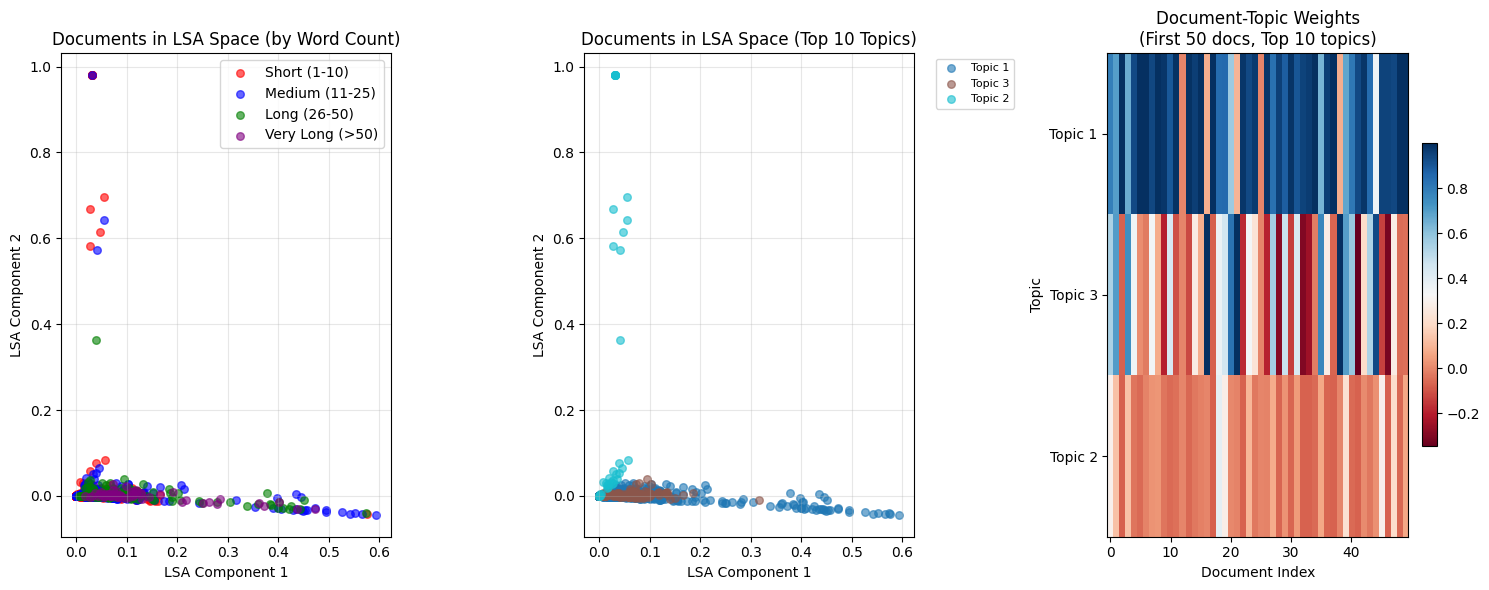

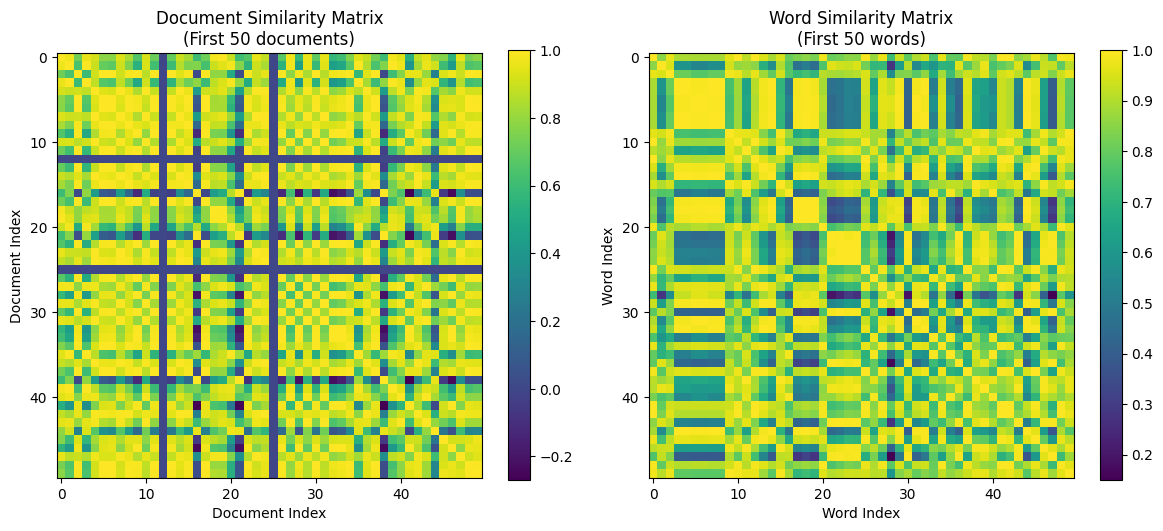

Visualizations completed!


In [46]:
# Create 2D visualization using first two LSA components
plt.figure(figsize=(15, 6))

# Plot 1: Documents in 2D LSA space colored by word count
plt.subplot(1, 3, 1)
# Create word count categories
word_count_categories = pd.cut(doc_topic_df['word_count'], 
                               bins=[0, 10, 25, 50, float('inf')], 
                               labels=['Short (1-10)', 'Medium (11-25)', 'Long (26-50)', 'Very Long (>50)'])

colors = ['red', 'blue', 'green', 'purple']
for i, category in enumerate(word_count_categories.cat.categories):
    mask = word_count_categories == category
    plt.scatter(lsa_matrix[mask, 0], lsa_matrix[mask, 1], 
               alpha=0.6, label=category, s=30, c=colors[i])

plt.xlabel('LSA Component 1')
plt.ylabel('LSA Component 2') 
plt.title('Documents in LSA Space (by Word Count)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Documents colored by dominant topic (show top 10 topics)
plt.subplot(1, 3, 2)
top_topics = doc_topic_df['dominant_topic'].value_counts().head(10).index
topic_colors = plt.cm.tab10(np.linspace(0, 1, len(top_topics)))

for i, topic in enumerate(top_topics):
    mask = doc_topic_df['dominant_topic'] == topic
    plt.scatter(lsa_matrix[mask, 0], lsa_matrix[mask, 1], 
               alpha=0.6, label=topic, s=30, c=[topic_colors[i]])

plt.xlabel('LSA Component 1')
plt.ylabel('LSA Component 2')
plt.title('Documents in LSA Space (Top 10 Topics)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)

# Plot 3: Topic weights heatmap
plt.subplot(1, 3, 3)
# Select top 10 topics by average weight for better visibility
top_topics_by_weight = doc_topic_df[topic_names].mean().abs().sort_values(ascending=False).head(10).index
topic_weights_subset = doc_topic_df[top_topics_by_weight].head(50)  # First 50 documents

im = plt.imshow(topic_weights_subset.T, cmap='RdBu', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xlabel('Document Index')
plt.ylabel('Topic')
plt.title('Document-Topic Weights\n(First 50 docs, Top 10 topics)')
plt.yticks(range(len(top_topics_by_weight)), [t.replace('Topic_', '') for t in top_topics_by_weight])

plt.tight_layout()
plt.show()

# Document similarity matrix visualization (sample)
plt.figure(figsize=(12, 5))

# Plot 1: Sample of document similarity matrix
plt.subplot(1, 2, 1)
sample_size = 50  # Show similarity for first 50 documents
sample_similarity = similarity_engine.doc_similarity_matrix[:sample_size, :sample_size]
im = plt.imshow(sample_similarity, cmap='viridis')
plt.colorbar(im)
plt.title(f'Document Similarity Matrix\n(First {sample_size} documents)')
plt.xlabel('Document Index')
plt.ylabel('Document Index')

# Plot 2: Word similarity matrix visualization (sample)
plt.subplot(1, 2, 2)
word_sample_size = 50  # Show similarity for first 50 words
sample_word_similarity = similarity_engine.word_similarity_matrix[:word_sample_size, :word_sample_size]
im = plt.imshow(sample_word_similarity, cmap='viridis')
plt.colorbar(im)
plt.title(f'Word Similarity Matrix\n(First {word_sample_size} words)')
plt.xlabel('Word Index')
plt.ylabel('Word Index')

plt.tight_layout()
plt.show()

print("Visualizations completed!")

## 10. Export Results to CSV

This section exports the LSA analysis results to CSV files for further analysis, visualization, and academic reporting.

In [47]:
# ============================================================================
# EXPORT TOPIC SUMMARY TO CSV
# ============================================================================

import pandas as pd
import os

def export_topic_summary_csv(term_topic_df, doc_topic_df, n_terms=15, output_dir="../results/"):
    """
    Export LSA topics summary with most representative terms to CSV
    """
    
    # Create results directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # TOPIC SUMMARY EXPORT - Most representative terms for each topic
    topics_export_data = []
    
    for i, topic_name in enumerate(term_topic_df.index):
        topic_weights = term_topic_df.iloc[i]
        
        # Get top terms by absolute weight (most representative)
        top_terms_abs = topic_weights.abs().sort_values(ascending=False).head(n_terms)
        
        # Get top positive and negative terms separately
        positive_terms = topic_weights[topic_weights > 0].sort_values(ascending=False).head(10)
        negative_terms = topic_weights[topic_weights < 0].sort_values(ascending=True).head(10)
        
        # Create topic summary
        topic_data = {
            'topic_number': i + 1,
            'topic_name': topic_name,
            'total_documents': len(doc_topic_df),
            'dominant_documents': (doc_topic_df['dominant_topic'] == topic_name).sum(),
            'dominance_percentage': (doc_topic_df['dominant_topic'] == topic_name).sum() / len(doc_topic_df) * 100,
            'average_weight': doc_topic_df[topic_name].mean(),
            'weight_std': doc_topic_df[topic_name].std()
        }
        
        # Add top terms (by absolute weight)
        for rank, (term, weight) in enumerate(top_terms_abs.items(), 1):
            topic_data[f'term_{rank:02d}'] = term
        
        # Add top positive terms
        for rank, (term, weight) in enumerate(positive_terms.head(5).items(), 1):
            topic_data[f'positive_term_{rank}'] = term
        
        # Add top negative terms
        for rank, (term, weight) in enumerate(negative_terms.head(5).items(), 1):
            topic_data[f'negative_term_{rank}'] = term
        
        topics_export_data.append(topic_data)
    
    # Convert to DataFrame and export
    topics_df = pd.DataFrame(topics_export_data)
    topics_csv_path = os.path.join(output_dir, "lsa_topics_summary.csv")
    topics_df.to_csv(topics_csv_path, index=False)
    
    print(f"✓ Topics summary exported to: {topics_csv_path}")
    
    return topics_df

# Execute the export
print("EXPORTING LSA TOPIC SUMMARY TO CSV")
print("=" * 40)
print(f"Model configuration: {n_topics} topics empirically determined")
print(f"Exporting {len(feature_names)} terms and {len(doc_topic_df)} documents")

# Export topic summary
topics_summary = export_topic_summary_csv(term_topic_df, doc_topic_df, n_terms=15)

print(f"\nEXPORT COMPLETE:")
print(f"• Topics Summary: {len(topics_summary)} topics with top 15 terms each")

# Display preview of the topics summary
print(f"\nPREVIEW: TOPICS SUMMARY")
print("=" * 40)
for _, row in topics_summary.iterrows():
    topic_num = int(row['topic_number'])
    topic_name = row['topic_name']
    dominance = row['dominance_percentage']
    top_terms = [row[f'term_{i:02d}'] for i in range(1, 6) if pd.notna(row[f'term_{i:02d}'])]
    
    print(f"{topic_name}: {dominance:.1f}% of documents")
    print(f"  Key terms: {', '.join(top_terms)}")
    print()

print("✓ Topic summary CSV export completed!")
print("File saved: '../results/lsa_topics_summary.csv'")

EXPORTING LSA TOPIC SUMMARY TO CSV
Model configuration: 3 topics empirically determined
Exporting 1000 terms and 978 documents
✓ Topics summary exported to: ../results/lsa_topics_summary.csv

EXPORT COMPLETE:
• Topics Summary: 3 topics with top 15 terms each

PREVIEW: TOPICS SUMMARY
Topic 1: 79.1% of documents
  Key terms: control, flood, flood control, project, projects

Topic 2: 3.9% of documents
  Key terms: hague, duterte, diba, digong, mean

Topic 3: 17.0% of documents
  Key terms: makukulong, discaya, tapos, control, state

✓ Topic summary CSV export completed!
File saved: '../results/lsa_topics_summary.csv'


## 10. Topic Quality Evaluation Metrics

This section implements advanced evaluation metrics to assess topic quality, including Topic Coherence and Topic Diversity measures.

### Topic Coherence (UMass)
- Even though coherence was originally used for probabilistic models (like LDA), it works fine for LSA because all you need are the top-N words per topic.
- Caveat: LSA components aren’t guaranteed to be “topics” in the strict sense, so coherence is more of a semantic interpretability check than a “native” metric.

### Topic Diversity
- LSA sometimes produces overlapping top terms across dimensions (because it captures correlated patterns).

### Topic Specialization
- How focused a topic is on a subset of documents vs. how broadly it is spread.

### Topic Strength
- Based on singular values / explained variance ratio (EVR) from the SVD decomposition.
- topics are statistically robust and contribute significantly to the LSA space.


INITIALIZING TOPIC QUALITY EVALUATOR
LSA TOPIC QUALITY EVALUATION
CALCULATING TOPIC COHERENCE (UMass)
Topic 1: -1.562 (top terms: control, flood, flood control, project, projects)
Topic 2: -2.020 (top terms: hague, duterte, diba, digong, mean)
Topic 3: -2.217 (top terms: makukulong, discaya, tapos, control, state)

AVERAGE TOPIC COHERENCE: -1.933

CALCULATING TOPIC DIVERSITY
Total unique top-10 words across all topics: 25
Total possible words (if no overlap): 30
Topic Diversity Score: 0.833
Average pairwise topic overlap: 0.167 (16.7%)

TOPIC OVERLAP ANALYSIS:
------------------------------
Topic 1 ↔ Topic 2: 0 shared words
Topic 1 ↔ Topic 3: 5 shared words
Topic 2 ↔ Topic 3: 0 shared words

CALCULATING TOPIC SPECIALIZATION
Topic 1: 0.102 (entropy: 8.79)
Topic 2: 0.145 (entropy: 5.91)
Topic 3: 0.112 (entropy: 7.91)

AVERAGE TOPIC SPECIALIZATION: 0.120

TOPIC QUALITY SUMMARY
Number of Topics: 3
Average Topic Coherence (UMass): -1.933
Topic Diversity Score: 0.833
Average Topic Overlap: 0

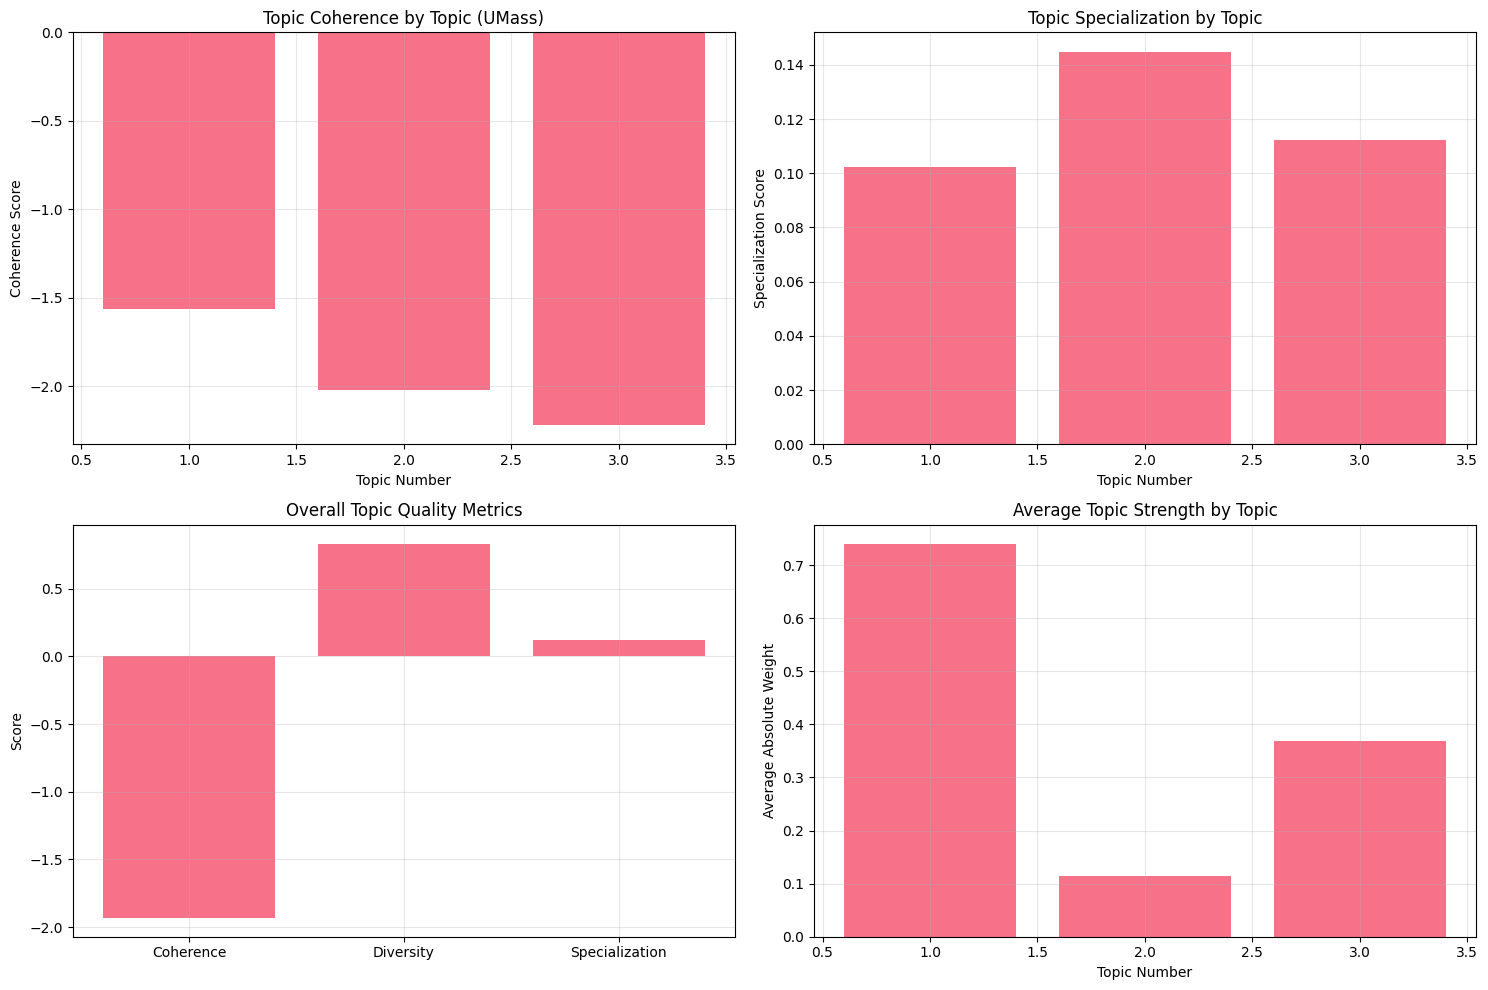


INTERPRETATION GUIDELINES
• Topic Coherence (UMass): Higher values indicate words frequently co-occur
• Topic Diversity: Higher values indicate less overlap between topics
• Topic Specialization: Higher values indicate more focused topics
• Topic Strength: Higher values indicate stronger document-topic associations

Optimal topic models show: High Coherence + High Diversity + Moderate Specialization


In [48]:
# ============================================================================
# TOPIC QUALITY EVALUATION METRICS
# ============================================================================

import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from itertools import combinations
import matplotlib.pyplot as plt

class TopicQualityEvaluator:
    """
    Comprehensive topic quality evaluation for LSA models
    """
    
    def __init__(self, term_topic_df, doc_topic_df, vectorizer, documents):
        self.term_topic_df = term_topic_df
        self.doc_topic_df = doc_topic_df
        self.vectorizer = vectorizer
        self.documents = documents
        self.feature_names = vectorizer.get_feature_names_out()
        self.n_topics = len(term_topic_df)
        
    def calculate_topic_coherence_umass(self, top_k=10):
        """
        Calculate UMass Topic Coherence
        Measures how often top words co-occur in the same documents
        Higher values indicate better coherence
        """
        coherence_scores = []
        
        print("CALCULATING TOPIC COHERENCE (UMass)")
        print("=" * 50)
        
        for topic_idx in range(self.n_topics):
            topic_name = f"Topic {topic_idx + 1}"
            
            # Get top-k terms for this topic
            topic_weights = self.term_topic_df.iloc[topic_idx]
            top_terms = topic_weights.abs().sort_values(ascending=False).head(top_k).index.tolist()
            
            # Calculate co-occurrence coherence
            coherence_sum = 0
            term_pairs = 0
            
            for i in range(len(top_terms)):
                for j in range(i + 1, len(top_terms)):
                    term_i, term_j = top_terms[i], top_terms[j]
                    
                    # Count documents containing both terms
                    docs_with_both = 0
                    docs_with_j = 0
                    
                    for doc in self.documents:
                        doc_lower = doc.lower()
                        has_i = term_i in doc_lower
                        has_j = term_j in doc_lower
                        
                        if has_j:
                            docs_with_j += 1
                        if has_i and has_j:
                            docs_with_both += 1
                    
                    # UMass coherence formula
                    if docs_with_j > 0:
                        coherence = np.log((docs_with_both + 1) / docs_with_j)
                        coherence_sum += coherence
                        term_pairs += 1
            
            topic_coherence = coherence_sum / term_pairs if term_pairs > 0 else 0
            coherence_scores.append(topic_coherence)
            
            print(f"{topic_name}: {topic_coherence:.3f} (top terms: {', '.join(top_terms[:5])})")
        
        avg_coherence = np.mean(coherence_scores)
        print(f"\nAVERAGE TOPIC COHERENCE: {avg_coherence:.3f}")
        
        return coherence_scores, avg_coherence
    
    def calculate_topic_diversity(self, top_k=10):
        """
        Calculate Topic Diversity
        Measures how unique the top words are across topics
        Higher values indicate better diversity (less overlap)
        """
        print("\nCALCULATING TOPIC DIVERSITY")
        print("=" * 50)
        
        all_top_words = set()
        topic_top_words = []
        
        # Collect top-k words for each topic
        for topic_idx in range(self.n_topics):
            topic_weights = self.term_topic_df.iloc[topic_idx]
            top_terms = topic_weights.abs().sort_values(ascending=False).head(top_k).index.tolist()
            topic_top_words.append(set(top_terms))
            all_top_words.update(top_terms)
        
        # Calculate diversity metrics
        total_unique_words = len(all_top_words)
        total_possible_words = self.n_topics * top_k
        
        # Topic Diversity = Unique words / Total possible words
        topic_diversity = total_unique_words / total_possible_words
        
        # Pairwise topic overlap analysis
        overlap_scores = []
        for i in range(self.n_topics):
            for j in range(i + 1, self.n_topics):
                overlap = len(topic_top_words[i].intersection(topic_top_words[j]))
                overlap_percentage = overlap / top_k
                overlap_scores.append(overlap_percentage)
        
        avg_overlap = np.mean(overlap_scores)
        
        print(f"Total unique top-{top_k} words across all topics: {total_unique_words}")
        print(f"Total possible words (if no overlap): {total_possible_words}")
        print(f"Topic Diversity Score: {topic_diversity:.3f}")
        print(f"Average pairwise topic overlap: {avg_overlap:.3f} ({avg_overlap*100:.1f}%)")
        
        # Display topic overlap matrix
        print(f"\nTOPIC OVERLAP ANALYSIS:")
        print("-" * 30)
        for i in range(self.n_topics):
            for j in range(i + 1, self.n_topics):
                overlap = len(topic_top_words[i].intersection(topic_top_words[j]))
                print(f"Topic {i+1} ↔ Topic {j+1}: {overlap} shared words")
        
        return topic_diversity, avg_overlap, topic_top_words
    
    def calculate_topic_specialization(self):
        """
        Calculate Topic Specialization
        Measures how focused each topic is (concentration of weights)
        """
        print("\nCALCULATING TOPIC SPECIALIZATION")
        print("=" * 50)
        
        specialization_scores = []
        
        for topic_idx in range(self.n_topics):
            topic_name = f"Topic {topic_idx + 1}"
            topic_weights = self.term_topic_df.iloc[topic_idx].abs()
            
            # Calculate entropy (lower entropy = more specialized)
            # Normalize weights to probabilities
            weights_norm = topic_weights / topic_weights.sum()
            weights_norm = weights_norm[weights_norm > 0]  # Remove zeros for log
            
            entropy = -np.sum(weights_norm * np.log2(weights_norm))
            specialization = 1 / (1 + entropy)  # Convert to specialization score
            
            specialization_scores.append(specialization)
            print(f"{topic_name}: {specialization:.3f} (entropy: {entropy:.2f})")
        
        avg_specialization = np.mean(specialization_scores)
        print(f"\nAVERAGE TOPIC SPECIALIZATION: {avg_specialization:.3f}")
        
        return specialization_scores, avg_specialization
    
    def calculate_comprehensive_metrics(self, top_k=10):
        """
        Calculate all topic quality metrics
        """
        print("LSA TOPIC QUALITY EVALUATION")
        print("=" * 70)
        
        # 1. Topic Coherence
        coherence_scores, avg_coherence = self.calculate_topic_coherence_umass(top_k)
        
        # 2. Topic Diversity
        diversity_score, avg_overlap, topic_words = self.calculate_topic_diversity(top_k)
        
        # 3. Topic Specialization
        specialization_scores, avg_specialization = self.calculate_topic_specialization()
        
        # 4. Additional metrics from existing analysis
        total_variance = np.sum([self.doc_topic_df[f"Topic {i+1}"].var() for i in range(self.n_topics)])
        avg_topic_strength = self.doc_topic_df['dominant_topic_weight'].mean()
        
        # Compile results
        results = {
            'n_topics': self.n_topics,
            'avg_topic_coherence': avg_coherence,
            'topic_diversity': diversity_score,
            'avg_topic_overlap': avg_overlap,
            'avg_topic_specialization': avg_specialization,
            'total_topic_variance': total_variance,
            'avg_topic_strength': avg_topic_strength,
            'coherence_by_topic': coherence_scores,
            'specialization_by_topic': specialization_scores
        }
        
        return results

# Initialize topic quality evaluator
print("INITIALIZING TOPIC QUALITY EVALUATOR")
print("=" * 50)
evaluator = TopicQualityEvaluator(term_topic_df, doc_topic_df, vectorizer, documents)

# Calculate comprehensive topic quality metrics
topic_quality_results = evaluator.calculate_comprehensive_metrics(top_k=10)

# Display summary results
print(f"\n" + "=" * 70)
print("TOPIC QUALITY SUMMARY")
print("=" * 70)
print(f"Number of Topics: {topic_quality_results['n_topics']}")
print(f"Average Topic Coherence (UMass): {topic_quality_results['avg_topic_coherence']:.3f}")
print(f"Topic Diversity Score: {topic_quality_results['topic_diversity']:.3f}")
print(f"Average Topic Overlap: {topic_quality_results['avg_topic_overlap']:.3f}")
print(f"Average Topic Specialization: {topic_quality_results['avg_topic_specialization']:.3f}")
print(f"Average Topic Strength: {topic_quality_results['avg_topic_strength']:.3f}")

# Visualize topic quality metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Topic Coherence by Topic
ax1.bar(range(1, topic_quality_results['n_topics'] + 1), topic_quality_results['coherence_by_topic'])
ax1.set_title('Topic Coherence by Topic (UMass)')
ax1.set_xlabel('Topic Number')
ax1.set_ylabel('Coherence Score')
ax1.grid(True, alpha=0.3)

# Plot 2: Topic Specialization by Topic
ax2.bar(range(1, topic_quality_results['n_topics'] + 1), topic_quality_results['specialization_by_topic'])
ax2.set_title('Topic Specialization by Topic')
ax2.set_xlabel('Topic Number')
ax2.set_ylabel('Specialization Score')
ax2.grid(True, alpha=0.3)

# Plot 3: Quality Metrics Comparison
metrics_names = ['Coherence', 'Diversity', 'Specialization']
metrics_values = [
    topic_quality_results['avg_topic_coherence'],
    topic_quality_results['topic_diversity'],
    topic_quality_results['avg_topic_specialization']
]
ax3.bar(metrics_names, metrics_values)
ax3.set_title('Overall Topic Quality Metrics')
ax3.set_ylabel('Score')
ax3.grid(True, alpha=0.3)

# Plot 4: Topic Strength Distribution
topic_strengths = [doc_topic_df[f"Topic {i+1}"].abs().mean() for i in range(topic_quality_results['n_topics'])]
ax4.bar(range(1, topic_quality_results['n_topics'] + 1), topic_strengths)
ax4.set_title('Average Topic Strength by Topic')
ax4.set_xlabel('Topic Number')
ax4.set_ylabel('Average Absolute Weight')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("INTERPRETATION GUIDELINES")
print("=" * 70)
print("• Topic Coherence (UMass): Higher values indicate words frequently co-occur")
print("• Topic Diversity: Higher values indicate less overlap between topics")
print("• Topic Specialization: Higher values indicate more focused topics")
print("• Topic Strength: Higher values indicate stronger document-topic associations")
print("\nOptimal topic models show: High Coherence + High Diversity + Moderate Specialization")